#**Predicting Happiness**

In this problem set you will work with a data set from the [World Happiness Website](https://worldhappiness.report/ed/2018/).

You will use the data in the file,  WHR2018Chapter2OnlineData.xls.

Our goal will be to develop a model for happiness.


# [DSLC Stage 1]: Domain Problem and Data Collection

Read the description of the data at the World Happiness Website.

**TODO: Add a text cell to answer the following questions:**

1. From your new domain knowledge, what variable will you use as a response or dependent variable for your model of happiness?

The response variable is average self-reported happiness (SWB, subjective well being) per capita as measured by the Cantril Ladder, in which 10 means the best possible life and 0 means the worst.

2. From your new domain knowledge, what variables will you consider as potential predictor (or independent) variables?

The predictor variables are

- GDP per capita as reported by the World Bank in September 2017, social support (average response to the question "If you were in trouble, do you have relatives or friends you can count on to help you whenever you need them, or not?", with 1 meaning yes and 0 meaning no, as reported by Gallup World Poll)
- healthy life expectancy at birth (extrapolated from WHO and WDI life and healthy life expectancy data)
- freedom (average response to "Are you satisfied or dissatisfied with your freedom to choose what you do with your life?")
- corruption (average response to 2 GWP questions: "Is corruption widespread throughout the government or not?" and "Is corruption widespread within businesses or not?", with the latter used if the former is missing)
- generosity (average donations to charity, regressed to average GDP). 
- positive affect (GWP measures for previous-day happiness, laughter, and enjoyment)
- negative affect (GWP measures for previous-day worry, sadness, and anger)
- inequality of household income (from GWP and World Bank, based on self reported income in both and government statistics in the latter)
- confidence in national government (GWP, "Do you have confidence in [the national government]")
- demoncratic and delivery quality of governance (WGI, based 6 other variables and transformed to have STD 1 and mean 0)
- trust (World Value Surveys, "...would you say that most people can be trusted or that you need to be very careful in dealing with people?")

Country and year could also act as predictor variables, but are used as primary keys in the dataset.

3. From your new domain knowledge, can you identify any variables that are cofounders?

All of the variables may, in theory, confound one another. Affect may be a confounded variable, since things that affect happiness likely also affect affect. Confidence, trust, government quality, and corruption may all confound one another. GDP also likely confounds many variables, like life expectancy, freedom, corruption, and trust.

4. Please share one question that you still have about the data collection process.

A question I have is how the generosity is regressed on GDP per capita. Does this eliminate the confound, or would it still exist? In addition, the GINI index was poorly defined in the report and appendices, what does it actually measure?


# [DSLC stage 2]: Data cleaning, pre-processing, and exploratory data analysis


In this section you will load and clean the data. Please run the code provide and complete modifications as specified.


In [1]:
# Installing scikit-lego package
%pip install scikit-lego kaleido
import plotly.io as pio
pio.renderers.default = "pdf"

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklego.linear_model import LADRegression



pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 100

In [3]:
# load the happiness data in file WHR2018Chapter2OnlineData.xls
# Upload this file using the folder to left
happiness_orig = pd.read_excel("WHR2018Chapter2OnlineData.xls", sheet_name=0)
happiness_orig

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-15","gini of household income reported in Gallup, by wp5-year"
0,Afghanistan,2008,3.723590,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,1.774662,0.476600,NaN,NaN,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,1.722688,0.391362,NaN,NaN,0.441906
2,Afghanistan,2010,4.758381,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,1.878622,0.394803,NaN,NaN,0.327318
3,Afghanistan,2011,3.831719,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,1.785360,0.465942,NaN,NaN,0.336764
4,Afghanistan,2012,3.782938,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,1.798283,0.475367,NaN,NaN,0.344540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,Zimbabwe,2013,4.690188,7.565154,0.799274,48.949745,0.575884,-0.076716,0.830937,0.711885,0.182288,0.527755,-1.026085,-1.526321,1.964805,0.418918,NaN,0.432,0.555439
1558,Zimbabwe,2014,4.184451,7.562753,0.765839,50.051235,0.642034,-0.045885,0.820217,0.725214,0.239111,0.566209,-0.985267,-1.484067,2.079248,0.496899,NaN,0.432,0.601080
1559,Zimbabwe,2015,3.703191,7.556052,0.735800,50.925652,0.667193,-0.094585,0.810457,0.715079,0.178861,0.590012,-0.893078,-1.357514,2.198865,0.593776,NaN,0.432,0.655137
1560,Zimbabwe,2016,3.735400,7.538829,0.768425,51.800068,0.732971,-0.065283,0.723612,0.737636,0.208555,0.699344,-0.863044,-1.371214,2.776363,0.743257,NaN,0.432,0.596690


In [4]:
# Examine the first 10 rows
happiness_orig.head(10)

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-15","gini of household income reported in Gallup, by wp5-year"
0,Afghanistan,2008,3.723590,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,-1.929690,-1.655084,1.774662,0.476600,NaN,NaN,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,-2.044093,-1.635025,1.722688,0.391362,NaN,NaN,0.441906
2,Afghanistan,2010,4.758381,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,-1.991810,-1.617176,1.878622,0.394803,NaN,NaN,0.327318
3,Afghanistan,2011,3.831719,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,-1.919018,-1.616221,1.785360,0.465942,NaN,NaN,0.336764
4,Afghanistan,2012,3.782938,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,-1.842996,-1.404078,1.798283,0.475367,NaN,NaN,0.344540
5,Afghanistan,2013,3.572100,7.503376,0.483552,51.042980,0.577955,0.074735,0.823204,0.620585,0.273328,0.482847,-1.879709,-1.403036,1.223690,0.342569,NaN,NaN,0.304368
6,Afghanistan,2014,3.130896,7.484583,0.525568,51.370525,0.508514,0.118579,0.871242,0.531691,0.374861,0.409048,-1.773257,-1.312503,1.395396,0.445686,NaN,NaN,0.413974
7,Afghanistan,2015,3.982855,7.466215,0.528597,51.693527,0.388928,0.094686,0.880638,0.553553,0.339276,0.260557,-1.844364,-1.291594,2.160618,0.542480,NaN,NaN,0.596918
8,Afghanistan,2016,4.220169,7.461401,0.559072,52.016529,0.522566,0.057072,0.793246,0.564953,0.348332,0.324990,-1.917693,-1.432548,1.796219,0.425627,NaN,NaN,0.418629
9,Afghanistan,2017,2.661718,7.460144,0.490880,52.339527,0.427011,-0.106340,0.954393,0.496349,0.371326,0.261179,NaN,NaN,1.454051,0.546283,NaN,NaN,0.286599


In [5]:
happiness_orig.sample(10)

,country,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect,Confidence in national government,Democratic Quality,Delivery Quality,Standard deviation of ladder by country-year,Standard deviation/Mean of ladder by country-year,GINI index (World Bank estimate),"GINI index (World Bank estimate), average 2000-15","gini of household income reported in Gallup, by wp5-year"
539,Guinea,2017,4.873723,7.527477,0.634026,51.151817,0.738213,0.054308,0.750026,0.704477,0.422461,0.639981,NaN,NaN,2.969935,0.609377,NaN,0.387000,0.618353
678,Jamaica,2017,5.889759,9.025865,0.913030,65.818794,0.860676,-0.130833,0.882796,0.769282,0.243400,0.348202,NaN,NaN,2.399338,0.407375,NaN,0.469000,0.564535
280,China,2009,4.454361,9.065514,0.798034,68.057518,0.771143,-0.177194,NaN,0.785806,0.161650,NaN,-1.075259,-0.263004,1.828763,0.410556,NaN,0.425000,0.566069
142,Bhutan,2013,5.569092,8.863728,0.818949,59.889400,0.810201,0.360623,0.802428,0.778723,0.217350,0.979501,0.312921,0.128376,1.283989,0.230556,NaN,0.412333,0.359662
1252,Somaliland region,2011,4.930572,NaN,0.787962,NaN,0.858104,NaN,0.357341,0.748686,0.122244,0.760764,NaN,NaN,1.967024,0.398944,NaN,NaN,0.537145
36,Argentina,2012,6.468387,9.863960,0.901776,66.836693,0.747498,-0.148023,0.816546,0.856516,0.272219,0.418255,0.199125,-0.572653,2.098197,0.324377,0.425,0.476067,0.317217
1002,Nicaragua,2011,5.385705,8.350311,0.800305,64.795502,0.778591,-0.017413,0.760243,0.791432,0.309019,0.539968,-0.423233,-0.673453,2.703564,0.501989,NaN,0.482750,0.507107
240,Canada,2009,7.487824,10.594738,0.942845,71.074837,0.915058,0.232484,0.412622,0.867433,0.247633,0.608264,1.264292,1.827809,1.612508,0.215351,NaN,0.336800,0.663210
855,Malaysia,2009,5.384702,9.908088,0.791666,64.084656,0.874320,-0.027878,0.858095,0.821611,0.163550,0.818659,-0.273138,0.421721,1.593053,0.295848,0.463,0.461000,0.471126
472,Gabon,2016,4.831764,9.728300,0.780049,56.713547,0.698942,-0.226151,0.816564,0.640117,0.432405,0.378070,-0.516068,-0.730402,2.214464,0.458314,NaN,0.422000,0.557237


Edit this cell to answer the following question:
5. Please share one question that you still have about the data itself
6. What is the observational unit in the data?

In [6]:
# 1. Calculate the percent of missingness of each variable in the data
happiness_orig_na = happiness_orig.isna().sum() / len(happiness_orig)
print(happiness_orig_na * 100)

# 2. Visualize the percent of missingness of each variable in a heatmap
px.imshow(
    happiness_orig.isna().astype(np.float64),
    title="Heatmap for NaN rows in World Happiness Report (2018)"
)

country                                                      0.000000
year                                                         0.000000
Life Ladder                                                  0.000000
Log GDP per capita                                           1.728553
Social support                                               0.832266
Healthy life expectancy at birth                             0.576184
Freedom to make life choices                                 1.856594
Generosity                                                   5.121639
Perceptions of corruption                                    5.761844
Positive affect                                              1.152369
Negative affect                                              0.768246
Confidence in national government                           10.307298
Democratic Quality                                          10.947503
Delivery Quality                                            10.947503
Standard deviation o

In [7]:
# This is a data cleaning function that is provided for you.
# Please feel free to modify this based on decisions you make
# during the pre-processing step. Document any changes you make and why.
def clean_happiness(happiness_orig, predictor_variable = None):
  # rename column names
  happiness_clean = happiness_orig.rename(columns={
    "Life Ladder": "happiness",
    "Log GDP per capita": "log_gdp_per_capita",
    "Social support": "social_support",
    "Healthy life expectancy at birth": "life_expectancy",
    "Freedom to make life choices": "freedom_choices",
    "Generosity": "generosity",
    "Perceptions of corruption": "corruption",
    "Positive affect": "positive_affect",
    "Negative affect": "negative_affect",
    "Confidence in national government": "government_confidence",
    "gini of household income reported in Gallup, by wp5-year": "gini_index"})
  # filter to relevant columns
  happiness_clean = happiness_clean[["country", "year", "happiness", "log_gdp_per_capita",
                                     "social_support", "life_expectancy",
                                     "freedom_choices", "generosity",
                                     "corruption", "positive_affect",
                                     "negative_affect", "government_confidence",
                                     "gini_index"]]

  if (predictor_variable is not None):
    happiness_clean = happiness_clean[["country", "year", "happiness", predictor_variable]]

  happiness_clean = happiness_clean.dropna(subset=["log_gdp_per_capita"])

  return(happiness_clean)


In [8]:
def impute(happiness_orig: pd.DataFrame):
    happiness_imputed = happiness_orig.copy()
    happiness_imputed["gini of household income reported in Gallup, by wp5-year"] = (
        happiness_imputed["gini of household income reported in Gallup, by wp5-year"]
            .fillna(happiness_imputed["GINI index (World Bank estimate)"])
            .fillna(happiness_imputed["GINI index (World Bank estimate), average 2000-15"])
    )
    return happiness_imputed

In [9]:
# Cleaning the data
happiness_clean = clean_happiness(impute(happiness_orig))
happiness_clean

,country,year,happiness,log_gdp_per_capita,social_support,life_expectancy,freedom_choices,generosity,corruption,positive_affect,negative_affect,government_confidence,gini_index
0,Afghanistan,2008,3.723590,7.168690,0.450662,49.209663,0.718114,0.181819,0.881686,0.517637,0.258195,0.612072,NaN
1,Afghanistan,2009,4.401778,7.333790,0.552308,49.624432,0.678896,0.203614,0.850035,0.583926,0.237092,0.611545,0.441906
2,Afghanistan,2010,4.758381,7.386629,0.539075,50.008961,0.600127,0.137630,0.706766,0.618265,0.275324,0.299357,0.327318
3,Afghanistan,2011,3.831719,7.415019,0.521104,50.367298,0.495901,0.175329,0.731109,0.611387,0.267175,0.307386,0.336764
4,Afghanistan,2012,3.782938,7.517126,0.520637,50.709263,0.530935,0.247159,0.775620,0.710385,0.267919,0.435440,0.344540
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,Zimbabwe,2013,4.690188,7.565154,0.799274,48.949745,0.575884,-0.076716,0.830937,0.711885,0.182288,0.527755,0.555439
1558,Zimbabwe,2014,4.184451,7.562753,0.765839,50.051235,0.642034,-0.045885,0.820217,0.725214,0.239111,0.566209,0.601080
1559,Zimbabwe,2015,3.703191,7.556052,0.735800,50.925652,0.667193,-0.094585,0.810457,0.715079,0.178861,0.590012,0.655137
1560,Zimbabwe,2016,3.735400,7.538829,0.768425,51.800068,0.732971,-0.065283,0.723612,0.737636,0.208555,0.699344,0.596690


Edit this cell to answer the following question:

7. What variables were dropped from the original data set?  Would you drop any additional variables from this data set and why?

The deleted variables are:

- Democratic Quality
- Delivery Quality
- Standard deviation of ladder by country-year
- Standard deviation/Mean of ladder by country-year
- GINI index (World Bank estimate)
- GINI index (World Bank estimate), average 2000-15

The standard deviations are derived variables, democratic and delivery quality had a lot of null values (>10%) and were poorly defined, and the World Bank GINI index estimates had a lot of null values.

Government confidence might also be considered to be dropped as it also has a high proportion (>10%) of null values.

8. How would you impute the gini_index variable? Explain why. (You do not have to write code to do this unless you need to do so for your model. In this case, include an imputation function and call it from the data cleaning function)

To impute the `gini_index` variable, one could take the World Bank estimates (the average if required) if the `gini_index` is NaN. As shown below, this removed all but 36 of the NaN values. comparing the statics on the field before and after, the mean, STD, and percentiles did not drastically change, so this method may be valid.

In [10]:
print(f"#NA after impute: {happiness_clean["gini_index"].isna().sum()}")
print("\n\nBEFORE:")
print(happiness_orig["gini of household income reported in Gallup, by wp5-year"].describe())
print("\n\nAFTER:")
print(happiness_clean["gini_index"].describe())

#NA after impute: 36


BEFORE:
count    1205.000000
mean        0.445204
std         0.105410
min         0.223470
25%         0.368531
50%         0.425395
75%         0.508579
max         0.961435
Name: gini of household income reported in Gallup, by wp5-year, dtype: float64


AFTER:
count    1499.000000
mean        0.433817
std         0.103580
min         0.223470
25%         0.357906
50%         0.417843
75%         0.494689
max         0.961435
Name: gini_index, dtype: float64


Now we will visualize the relationships between variables.

# Plot Guidelines
For all plots and visualizations for this assignment please include


*   Captions: Descriptive captions summarizing the plot's insights.
*   Legends: Clear legends identifying each element in the plot.
*   Axis Labels: Informative labels for both the x and y axes, including units if applicable.
* Style: appropriate colors, font sizes, and plot layouts for better readability and presentation.

*It is important that your visualizations are easy-to-understand plots.*

In [11]:
# Since we are predicting happiness, we need to figure out what variable to use
# as a predictor.
# 1. Calculate the correlation between the happiness variable
#   and your set of remaining potential predictor variables
px.imshow(
    happiness_clean.select_dtypes(include="number").corr(),
    text_auto=True,
    title="Correlation between Variables in World Happiness Report (2018)"
)
# 2. Visualize the correlations between the dependent variable

9. From this investigation, what variable do you choose as your predictor and why?

The variables with highest correlation to happiness are GDP per capita, social support, life expectancy, freedom, and positive affect, all with magnitude greater than 0.5.

The most highly correlated variable is GDP, so I will choose that as my predictor. Life expectancy, freedom, and positive affect may all be confounded with GDP, so it might be a bad idea to choose these. Social support is also a good choice and may be less confounded with GDP, though that is an informal guess.

**Separate data into training and validation sets**

During this stage it is important that we choose data sets for training predictive models and validating predictive models.

In [12]:
# (You do not need to worry about a test set right now)
# Explain your decision to separate the data this way.
# You will reuse these data subsets in the following DSLC stage.

# you can use sklearn.train_test_split
def partition(df: pd.DataFrame, proportion: float = 0.6, random_state=None) -> pd.DataFrame:
    shuffled = df.sample(frac=1, random_state=random_state)
    partition1_size = int(proportion * len(shuffled))
    return (shuffled[:partition1_size], shuffled[partition1_size:])

(happiness_train, happiness_test_val) = partition(happiness_clean, 0.6, random_state=99999)
happiness_train

,country,year,happiness,log_gdp_per_capita,social_support,life_expectancy,freedom_choices,generosity,corruption,positive_affect,negative_affect,government_confidence,gini_index
516,Greece,2013,4.720251,10.075173,0.686650,71.250137,0.425967,-0.277970,0.941310,0.689162,0.482183,0.143609,0.319988
390,Dominican Republic,2016,5.238698,9.553850,0.894753,63.335289,0.872712,-0.085081,0.737183,0.759946,0.278095,0.549425,0.484080
200,Burkina Faso,2008,3.846439,7.239715,0.726651,47.875610,0.612064,-0.089791,0.887124,0.523474,0.303892,0.462705,0.394667
566,Hong Kong S.A.R. of China,2010,5.642835,10.781198,0.857314,74.827393,0.890418,0.314442,0.255775,0.710370,0.183106,0.634737,0.435544
254,Chad,2007,4.141327,7.462495,0.478951,42.016632,0.294612,-0.020856,0.873610,0.613522,0.245208,0.228145,0.415500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,Netherlands,2010,7.501876,10.726009,0.956537,70.739174,0.921448,0.337370,0.398592,0.853234,0.206079,0.636186,0.464675
1503,Uzbekistan,2015,5.972364,8.648263,0.968225,62.896912,0.979937,0.370149,0.470917,0.839981,0.103494,0.973944,0.356073
84,Azerbaijan,2015,5.146775,9.723096,0.785703,62.864544,0.764289,-0.221827,0.615553,0.606569,0.206114,0.788487,0.287745
426,El Salvador,2016,6.139825,8.985946,0.793660,64.094536,0.799847,-0.193339,0.797312,0.761256,0.345736,0.251705,0.457765


A random sample seemed to be adequate to partition the data.

# [DSLC stage 4]: Predictive analysis

In this section we will examine the relationship between happiness as the response variable and your predictor variable. First we will visualize the relationship between happiness and the predictor variable.

<Axes: title={'center': 'Log GDP Per Capita vs. Happiness in World Happiness Report (2018)'}, xlabel='Log GDP Per Capita (International dollar)', ylabel='Happiness'>

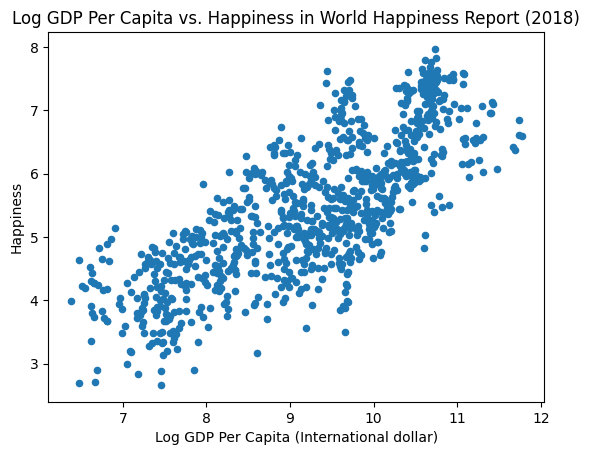

In [13]:
# 1. Create data frames that only contain columns for
# country, year, happiness, and your predictor variable
predictor = "log_gdp_per_capita"
predictor_label = "Log GDP Per Capita (International dollar)"
columns = ["country", "year", "happiness", predictor]
happiness_train_filtered = happiness_train[columns]
happiness_val_filtered = happiness_train[columns]

# 2. Create a scatterplot of happiness vs your predictor variable
happiness_train_filtered.plot.scatter(
    x=predictor, y="happiness",
    xlabel=predictor_label, ylabel="Happiness",
    title="Log GDP Per Capita vs. Happiness in World Happiness Report (2018)",
)


# Modeling the relationship
**Using your training data set**

Train the LAD (L1 loss) and LS (L2 loss) linear fits for predicting happiness  based on your chosen predictor variable of your choosing.

*Once you have completed this, edit this cell here to report the formulas for your fitted models.*

LAD: y=0.73209501 X + -1.3832882612278787s
LS: y=0.74976482 X + -1.4894560279254465

For the LAD model you will use  LADRegression from sklego.linear_model. Examples are available in the L04 notebook and [API documentation](https://koaning.github.io/scikit-lego/user-guide/linear-models/#least-absolute-deviation-regression)

In [14]:
# 1. Train LAD model on your training Set
from sklego.linear_model import LADRegression

X_train = happiness_train_filtered[predictor].to_numpy().reshape(-1, 1)
y_train = happiness_train_filtered["happiness"].to_numpy()
X_val = happiness_val_filtered[predictor].to_numpy().reshape(-1, 1)
y_val = happiness_val_filtered["happiness"].to_numpy()

lad_reg = LADRegression()
lin_reg = LinearRegression()

# 2. Get the parameters of your model to write formula

# 3. Train LS model on your training Set
lad_reg.fit(X_train, y_train)

# 4. Get the parameters of your model to write formula
lad_m = lad_reg.coef_
lad_b = lad_reg.intercept_
print(f"LAD: y={lad_m}X + {lad_b}")


LAD: y=[0.69954264]X + -1.0436701364130059


For the LS model you will use  LinearRegression from sklearn.linear_model. Examples are available in the L04 notebook and [API documentation](https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LinearRegression.html)

LS: y=[0.73629989]X + -1.333753801778899


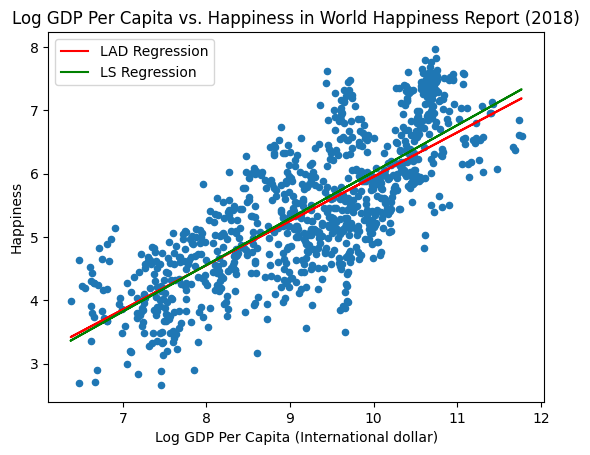

In [15]:
# 3. Train LS model on your training Set
lin_reg.fit(X_train, y_train)

# 4. Get the parameters of your model to write formula
lin_m = lin_reg.coef_
lin_b = lin_reg.intercept_
print(f"LS: y={lin_m}X + {lin_b}")

# 5. Create a scatterplot of happiness vs your predictor variable
#    with a line for each model

happiness_train_filtered.plot.scatter(
    x=predictor, y="happiness",
    xlabel=predictor_label, ylabel="Happiness",
    title="Log GDP Per Capita vs. Happiness in World Happiness Report (2018)",
)
lad_y = lad_m * happiness_train_filtered[predictor] + lad_b
lin_y = lin_m * happiness_train_filtered[predictor] + lin_b
plt.plot(happiness_train_filtered[predictor], lad_y, color="red", label="LAD Regression")
plt.plot(happiness_train_filtered[predictor], lin_y, color="green", label="LS Regression")

plt.legend()


Now we'd like to evaluate how each model has done.

**Using your validation data set**

Compute the rMSE, MAE, MAD, correlation and  $R^2$  evaluations for each algorithm.

In [16]:
# Create a  3 column dataframe that for each point in your validation set
# contains the actual observed happiness score, the happiness score predicted
# from LAD, and the happiness score predicted from LS
predictions = pd.DataFrame({
    "happiness": y_val,
    "lad_happiness": lad_reg.predict(X_val),
    "ls_happiness": lin_reg.predict(X_val),
})

<Axes: xlabel='happiness', ylabel='lad_happiness'>

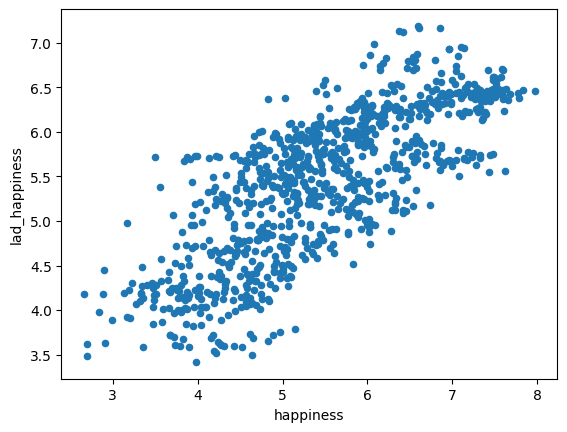

In [17]:
# Create a scatterplot of the observed happiness score vs
# the happiness score predicted from LAD
# What would a perfect prediction look like?
#       A perfect predictino would look like a straight line
predictions.plot.scatter(x="happiness", y="lad_happiness")

<Axes: xlabel='happiness', ylabel='ls_happiness'>

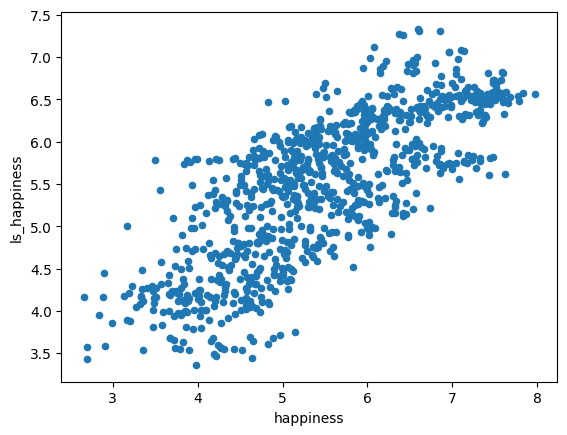

In [18]:
# Create a scatterplot of the observed happiness score vs
# the happiness score predicted from LS
# What would a perfect prediction look like?
#           A straight line
predictions.plot.scatter(x="happiness", y="ls_happiness")

In [19]:
# Write code in this cell to calculate and print
# the rMSE, MAE, MAD, correlation, and R2 of
# the true price with the LS and LAD predictions
def print_stats(real: pd.Series, pred: pd.Series):
    print("RMSE: ", mean_squared_error(real, pred)**0.5)
    print("MAE: ", mean_absolute_error(real, pred))
    print("MAD: ", (pred - real).abs().mean())
    print("Correlation: ", real.corr(pred))
    print("R2: ", r2_score(real, pred))

print("LAD")
print_stats(predictions["happiness"], predictions["lad_happiness"])
print()
print("LS")
print_stats(predictions["happiness"], predictions["ls_happiness"])

LAD
RMSE:  0.713868629854809
MAE:  0.5859002753981548
MAD:  0.5859002753981548
Correlation:  0.7778832435688353
R2:  0.6016712520024537

LS
RMSE:  0.7107874514606999
MAE:  0.5880119028196019
MAD:  0.5880119028196019
Correlation:  0.777883243568835
R2:  0.6051023406251717


**Evaluating the models**

Based on the scatterplots and evaluation metrics that you have calculated, what model is better for the relationship between happiness and your predictor variable? Please explain why with supporting evidence from your plots and calculations.

Both models performed about the same. LS had slightly higher R2 score, but this was dependent on the sample (as well as all other error metrics);

**Citation:**

This problem set is adapted from Ch. 9 exercise 22 from the following upcoming book:

Yu, B., & Barter, R. L. (2024). Veridical data science: The practice of responsible data analysis and decision making. The MIT Press.